---
NOTE: This lab references some (commercial) training material on [ChipWhisperer.io](https://www.ChipWhisperer.io). You can freely execute and use the lab per the open-source license (including using it in your own courses if you distribute similarly), but you must maintain notice about this source location. Consider joining our training course to enjoy the full experience.

---

**SUMMARY:** *Last time, we saw how correlation can be used to recover an AES key, as well as the effectiveness of such an attack. In this lab, we'll repeat the attack with ChipWhisperer Analyzer and gain some additional information about the attack*

**LEARNING OUTCOMES:**

* Use ChipWhisperer Analyzer to perform a CPA attack
* Plot additional information about the attack

## Prerequisites

Hold up! Before you continue, check you've done the following tutorials:

* ☑ CPA on Firmware Implementation of AES (you should understand how a CPA attack works).
* ☑ SCA101 Intro (you should have an idea of how to get hardware-specific versions running).

In [1]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEARM'
CRYPTO_TARGET = 'TINYAES128C'
num_traces = 50
CHECK_CORR = False

In [2]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET"
cd ../../../hardware/victims/firmware/simpleserial-aes
make PLATFORM=$1 CRYPTO_TARGET=$2

Building for platform CWLITEARM with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
rm -f -- simpleserial-aes-CWLITEARM.hex
rm -f -- simpleserial-aes-CWLITEARM.eep
rm -f -- simpleserial-aes-CWLITEARM.cof
rm -f -- simpleserial-aes-CWLITEARM.elf
rm -f -- simpleserial-aes-CWLITEARM.map
rm -f -- simpleserial-aes-CWLITEARM.sym
rm -f -- simpleserial-aes-CWLITEARM.lss
rm -f -- objdir/*.o
rm -f -- objdir/*.lst
rm -f -- simpleserial-aes.s simpleserial.s stm32f3_hal.s stm32f3_hal_lowlevel.s stm32f3_sysmem.s aes.s aes-independant.s
rm -f -- simpleserial-aes.d simpleserial.d stm32f3_hal.d stm32f3_hal_lowlevel.d stm32f3_sysmem.d aes.d aes-independant.d
rm -f -- simpleserial-aes.i simpleserial.i stm32f3_hal.i stm32f3_hal_lowlevel.i stm32f3_sysmem.i aes.i aes-independant.i
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc.exe (GNU Tools for ARM Embedded Processors 6-2017-q1-update) 6.3.1 20170215 (release) [ARM/embedded-6-branch

In [29]:
import chipwhisperer as cw
scope = cw.scope()
target = cw.target(scope)
scope.default_setup()

if "STM" in PLATFORM or PLATFORM == "CWLITEARM" or PLATFORM == "CWNANO":
    prog = cw.programmers.STM32FProgrammer
elif PLATFORM == "CW303" or PLATFORM == "CWLITEXMEGA":
    prog = cw.programmers.XMEGAProgrammer
else:
    prog = None
    
import time
time.sleep(0.05)
scope.default_setup()
def reset_target(scope):
    if PLATFORM == "CW303" or PLATFORM == "CWLITEXMEGA":
        scope.io.pdic = 'low'
        time.sleep(0.05)
        scope.io.pdic = 'high_z' #XMEGA doesn't like pdic driven high
        time.sleep(0.05)
    else:  
        scope.io.nrst = 'low'
        time.sleep(0.05)
        scope.io.nrst = 'high_z'
        time.sleep(0.05)

Serial baud rate = 38400


In [58]:
scope.clock.clkgen_freq = 161E6

In [59]:
print(scope.clock.adc_freq)

160999992


In [4]:
cw.program_target(scope, prog, "../../../hardware/victims/firmware/simpleserial-aes/simpleserial-aes-{}.hex".format(PLATFORM))

Serial baud rate = 115200
Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 5971 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 5971 bytes
Serial baud rate = 38400


In [5]:
from tqdm import tnrange
import numpy as np
import time

ktp = cw.ktp.Basic()
trace_array = []
textin_array = []



proj = cw.create_project("Lab 4_3", overwrite=True)

N = 50
for i in tnrange(N, desc='Capturing traces'):
    key, text = ktp.next()
    trace = cw.capture_trace(scope, target, text, key)
    if not trace:
        continue
    
    proj.traces.append(trace)

In [11]:
scope.dis()
target.dis()

## Blah

There's no need for any models or SBox implementaions, or anything like that this time. Instead, everything's contained in ChipWhisperer Analyzer. Another change from previous tutorials is that we're using ChipWhisperer projects instead of numpy arrays, since most of ChipWhisperer Analyzer only works with ChipWhisperer projects.

Before we continue on with our CPA attack, let's take a quick look at the projects:

In [9]:
# we can access wave, textin, etc as a whole with proj.traces
for trace in proj.traces:
    print(trace.wave[0], trace.textin, trace.textout, trace.key)

# can also access individually with proj.waves, proj.textins, etc.
for wave in proj.waves:
    print(wave[0])

0.0400390625 CWbytearray(b'22 2b 99 56 a0 e7 59 6b e9 69 36 c0 5b 5e e3 23') CWbytearray(b'00 da 45 bd f4 43 56 06 51 57 89 2b 82 53 dc 2c') CWbytearray(b'2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c')
0.0390625 CWbytearray(b'de 2f 1d d0 00 42 6f 20 5a 5d a4 48 ac 95 84 57') CWbytearray(b'51 ca c2 94 af b3 d9 d5 7e 42 cc 6b 44 5c 1f c8') CWbytearray(b'2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c')
0.0419921875 CWbytearray(b'20 75 e6 0c 20 08 65 e7 1a c8 5c 45 3a f6 75 58') CWbytearray(b'57 a0 1b 3d cc c8 0f aa b6 f6 17 84 b5 47 df df') CWbytearray(b'2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c')
0.0400390625 CWbytearray(b'91 87 3b e1 08 ed eb 9b 77 a4 b6 a7 46 6f 84 b1') CWbytearray(b'1b eb b4 88 7b a8 07 80 ce 6a 16 89 9d 4c 14 ff') CWbytearray(b'2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c')
0.04296875 CWbytearray(b'8e 54 ab a5 42 70 f5 6b 17 8d 2c c8 a6 6d 45 eb') CWbytearray(b'49 b8 19 72 68 46 01 10 f7 23 db 89 05 6a 6f e0') CWbytearray(b'2b 7e 15 16 28 ae d2 a6 ab f7 

0.0419921875 CWbytearray(b'a4 0e ed 69 9e 35 84 8d e2 f4 4a 0a d4 d8 30 a3') CWbytearray(b'4c 93 a6 02 8a 8c 1c 98 e1 c7 0f d2 be a9 2c 56') CWbytearray(b'2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c')
0.0380859375 CWbytearray(b'bf 11 62 cc 55 9d de 9f d4 ad 8a c0 83 68 5b d4') CWbytearray(b'ff 09 b9 db 60 03 0d 6a 53 23 97 df 59 fd 03 5a') CWbytearray(b'2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c')
0.0400390625 CWbytearray(b'16 3c 78 00 f7 b8 c2 c0 84 51 35 de e1 71 11 da') CWbytearray(b'e0 28 53 9f a6 58 60 9b 64 92 7a c0 50 29 bf dc') CWbytearray(b'2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c')
0.046875 CWbytearray(b'da c9 8e 76 cc 7d 26 ef 73 4f 09 aa eb 6a a4 a0') CWbytearray(b'b8 08 48 3f 2c 06 23 3b 90 22 2b 48 c7 7c e6 0f') CWbytearray(b'2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c')
0.044921875 CWbytearray(b'0d 4e 07 2c 28 78 02 0a 18 c6 59 46 d0 26 81 ae') CWbytearray(b'aa 60 95 c2 3c 38 60 73 4f 31 c2 a1 5c 4a 96 59') CWbytearray(b'2b 7e 15 16 28 ae d2 a6 ab f7 

We can access Analyzer via `chipwhisperer.analyzer`:

In [13]:
import chipwhisperer.analyzer as cwa

We also have to set our leakage model to be the SBox output. ChipWhisperer Analyzer includes a bunch of different leakage models which are useful in different situations. We'll look more at that in SCA201, however.

In [16]:
leak_model = cwa.leakage_models.sbox_output

The rest of the setup only takes 1 line:

In [17]:
attack = cwa.cpa(proj, leak_model)

If you want to see the attack settings, you can print the cpa object:

In [18]:
print(attack)

project     = <chipwhisperer.common.api.ProjectFormat.Project object at 0x000002D67D16A548>
leak_model  = <chipwhisperer.analyzer.attacks.models.AES128_8bit.AES128_8bit object at 0x000002D67D4E2188>
algorithm   = <chipwhisperer.analyzer.attacks.cpa_algorithms.progressive.CPAProgressive object at 0x000002D67D4E1808>
trace_range = [0, 50]
point_range = [0, 5000]
subkey_list = range(0, 16)



Running the attack is also done in a single line:

In [19]:
results = attack.run()

Let's see if we got the AES key:

In [20]:
print(results)

Subkey KGuess Correlation
  00    0x2B    0.84277
  01    0x7E    0.90034
  02    0x15    0.89795
  03    0x16    0.82918
  04    0x28    0.89928
  05    0xAE    0.90245
  06    0xD2    0.85025
  07    0xA6    0.89473
  08    0xAB    0.84284
  09    0xF7    0.81530
  10    0x15    0.93647
  11    0x88    0.90777
  12    0x09    0.87611
  13    0xCF    0.83972
  14    0x4F    0.89832
  15    0x3C    0.86969



We can get the full information from the attack by calling `results.find_maximums()`, which returns:

```Python
find_maxiums() ->
    [subkey0_data, subkey1_data, subkey2_data, ...]
    
subkey0_data ->
    [guess0, guess1, guess2, ...]
    
guess0 ->
    (key_guess, location_of_max, correlation)
```

For example, if you want to print the correlation of the third best guess of the 4th subkey, you would run:

```python
print(attack_results.find_maximums()[4][3][2])
```

Note the "point location of the max" is normally not calculated/tracked, and thus returns as a 0. Using the pandas library lets us print them nicely in a DataFrame. We have to transpose the frame to get our expected orientation:

In [21]:
import pandas as pd
stat_data = results.find_maximums()
df = pd.DataFrame(stat_data).transpose()
print(df.head())

                              0                             1  \
0   [43, 0, 0.8427687087674894]  [126, 0, 0.9003356957811618]   
1   [95, 0, 0.6691477812930219]   [39, 0, 0.6476082553951066]   
2  [132, 0, 0.6580106199426445]  [243, 0, 0.6267143053254428]   
3  [189, 0, 0.6400152212809219]  [234, 0, 0.6101481811303967]   
4  [186, 0, 0.6210566477542531]  [252, 0, 0.5831642703314558]   

                              2                             3  \
0   [21, 0, 0.8979518869213197]   [22, 0, 0.8291821221120868]   
1   [66, 0, 0.6234988363746862]  [206, 0, 0.6775511651499049]   
2  [166, 0, 0.6057241977558485]   [52, 0, 0.6069557587796215]   
3  [141, 0, 0.5950158100226696]    [6, 0, 0.6066897757565102]   
4  [238, 0, 0.5797114260018909]  [219, 0, 0.6044237168839883]   

                              4                             5  \
0    [40, 0, 0.899281972279763]  [174, 0, 0.9024470141674069]   
1    [204, 0, 0.64545542375814]  [201, 0, 0.6517235396831818]   
2  [105, 0, 0.622786299

Even better, we can use the `.style` method to customize this further. This also lets us chain formatting functions. For example, we can remove the extra 0 and clean up the data. Since we know the correct key, we can even do things like printing the key in a different colour! 

You can do lots of formatting thanks to the pandas library! Check out https://pandas.pydata.org/pandas-docs/stable/style.html for more details.

In [22]:
key = proj.keys[0]
def format_stat(stat):
    return str("{:02X}<br>{:.3f}".format(stat[0], stat[2]))

def color_corr_key(row):
    global key
    ret = [""] * 16
    for i,bnum in enumerate(row):
        if bnum[0] == key[i]:
            ret[i] = "color: red"
        else:
            ret[i] = ""
    return ret

df.head().style.format(format_stat).apply(color_corr_key, axis=1)

You should see red numbers printed at the top of a table. Congratulations, you've now completed a successful CPA attack against AES!

Next, we'll look at how we can use some of Analyzer's other features to improve the attack process, as well as better interpret the data we have.

## Reporting Intervals

When we ran `attack.run()`, we processed all of the traces before getting any information back. ChipWhisperer Analyzer actually uses the "online" correlation calculation that we mentioned last time, meaning we can get feedback during the attack. This can be done by creating a callback function and passing it to `attack.run()`. This function is called each time we pass the update interval (default 25, which is the second parameter for `attack.run()`).

Let's use this to update our table every 10 traces. Most of this is just putting our existing code into the callback function. We also need use the `clear_output` function to clear the table, as well as `display()` to actually get it to show up:

In [23]:
from IPython.display import clear_output
import numpy as np
        
def stats_callback():
    results = attack.results
    results.set_known_key(key)
    stat_data = results.find_maximums()
    df = pd.DataFrame(stat_data).transpose()
    clear_output(wait=True)
    display(df.head().style.format(format_stat).apply(color_corr_key,axis=1))
    
results = attack.run(stats_callback, 10)

A default jupyter callback is also available - the following **three lines** are all you need to run an attack!

In [24]:
import chipwhisperer as cw
cb = cwa.get_jupyter_callback(attack)
results = attack.run(cb, 10)

Here we used a reporting interval of 10 traces. Depending on the attack and what you want to learn from it, you may want to use higher or lower values: in general reporting less often is faster, but more frequent reporting can allow you to end a long attack early. More frequent reporting also increases the resolution of some plot data (which we will look at next).

## Plot Data

Analyzer also includes a module to create plots to help you interpret the data. These act on one subkey at a time and return some data that we can plot using bokeh (or your graphing module of choice). Let's start by grabbing the class that does all the calculations:

In [25]:
plot_data = cwa.analyzer_plots(results)

We'll start by looking at the Output Vs. Time module, which will allow us to plot correlation of our guesses in time. This is useful for finding exactly where the operations we're attacking are. Like in previous tutorials, we'll use bokeh to plot the data we get back.

The method we're interested in is `get_plot_data(bnum)`, which returns in a list: `[xrange, correct_key, incorrect_key_data, incorrect_key_data]` for the position `bnum` passed to it. The method returns two sets of incorrect key data because one is for the key guesses below the correct one, and the other is for guesses above the correct one.

We'll have a lot of points, so we'll plot as usual, but at the end decimate the output:

C:\Users\adewar\Downloads\WPy64-3760\python-3.7.6.amd64\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\adewar\Downloads\WPy64-3760\python-3.7.6.amd64\lib\site-packages\fastparquet\dataframe.py:5: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import CategoricalIndex, RangeIndex, Index, MultiIndex
C:\Users\adewar\AppData\Roaming\Python\Python37\site-packages\datashader\transfer_functions.py:21: FutureWarning: xarray subclass Image should explicitly define __slots__
  class Image(xr.DataArray):


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
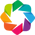

:DynamicMap   []
   :Overlay
      .Curve.I      :Curve   [Sample]   (0)
      .Curve.II     :Curve   [index]   (1)
      .Curve.III    :Curve   [index]   (2)
      .Curve.IV     :Curve   [index]   (3)
      .Curve.V      :Curve   [index]   (4)
      .Curve.VI     :Curve   [index]   (5)
      .Curve.VII    :Curve   [index]   (6)
      .Curve.VIII   :Curve   [index]   (7)
      .Curve.IX     :Curve   [index]   (8)
      .Curve.X      :Curve   [index]   (9)
      .Curve.XI     :Curve   [index]   (10)
      .Curve.XII    :Curve   [index]   (11)
      .Curve.XIII   :Curve   [index]   (12)
      .Curve.XIV    :Curve   [index]   (13)
      .Curve.XV     :Curve   [index]   (14)
      .Curve.XVI    :Curve   [index]   (15)
      .Curve.XVII   :Curve   [index]   (0)
      .Curve.XVIII  :Curve   [index]   (1)
      .Curve.XIX    :Curve   [index]   (2)
      .Curve.XX     :Curve   [index]   (3)
      .Curve.XXI    :Curve   [index]   (4)
      .Curve.XXII   :Curve   [index]   (5)
      .Curve.XXIII  :Curve   [index]   (6)
      .Curve.XXIV   :Curve   [index]   (7)
      .Curve.XXV    :Curve   [index]   (8)
      .Curve.XXVI   :Curve   [index]   (9)
      .Curve.XXVII  :Curve   [index]   (10)
      .Curve.XXVIII :Curve   [index]   (11)
      .Curve.XXIX   :Curve   [index]   (12)
      .Curve.XXX    :Curve   [index]   (13)
      .Curve.XXXI   :Curve   [index]   (14)
      .Curve.XXXII  :Curve   [index]   (15)

In [26]:
def byte_to_color(idx):
    return hv.Palette.colormaps['Category20'](idx/16.0)

import holoviews as hv
from holoviews.operation.datashader import datashade, shade, dynspread, rasterize
from holoviews.operation import decimate
import pandas as pd, numpy as np

a = []
b = []
hv.extension('bokeh')
for i in range(0, 16):
    data = plot_data.output_vs_time(i)
    a.append(np.array(data[1]))
    b.append(np.array(data[2]))
    b.append(np.array(data[3]))
    
pda = pd.DataFrame(a).transpose().rename(str, axis='columns')
pdb = pd.DataFrame(b).transpose().rename(str, axis='columns')
curve = hv.Curve(pdb['0'], "Sample").options(color='black')
for i in range(1, 16):
    curve *= hv.Curve(pdb[str(i)]).options(color='black')
    
for i in range(0, 16):
    curve *= hv.Curve(pda[str(i)]).options(color=byte_to_color(i))
decimate(curve.opts(width=900, height=600))

You should see some distinctive spikes in your plot. The largest of these is where the sbox lookup is actually happening (the smaller ones are typically other AES operations that move the sbox data around). We are normally talking absolute values, so you'll see negatives in there.

This information can be useful in many ways. For example, you can probably see the first 16 spikes that make up the sbox lookup are a small portion of the total trace length. If we ever needed to rerun the attack, we could capture a much smaller number of samples and speed up analysis significantly!

### PGE vs. Traces

The next data we'll look at is a plot of partial guessing entropy (PGE) vs. the number of traces. As mentioned before, PGE is just how many spots away from the top the actual subkey is in our table of guesses. For example, if there are 7 subkey guesses that have a higher correlation than the actual subkey, the subkey has a PGE of 7.

This plot is useful for seeing how many traces were needed to actually break the AES implementation. Keep in mind, however, that the resolution of the plot is determined by the reporting interval (also note that `attack_results.find_maximums()` must be called in the callback function). In our case, we have a reporting interval of 10, so we'll have a resolution of 10 traces.

This method is similar to the previous plot in that it takes `bnum` as an argument and returns a list of `[xrange, PGE]`. 

In [27]:
ret = plot_data.pge_vs_trace(0)
curve = hv.Curve((ret[0],ret[1]), "Traces Used in Calculation", "Partial Guessing Entrop of Byte")
for bnum in range(1, 16):
    ret = plot_data.pge_vs_trace(bnum)
    curve *= hv.Curve((ret[0],ret[1])).opts(color=byte_to_color(bnum))
curve.opts(width=900, height=600)

:Overlay
   .Curve.I    :Curve   [Traces Used in Calculation]   (Partial Guessing Entrop of Byte)
   .Curve.II   :Curve   [x]   (y)
   .Curve.III  :Curve   [x]   (y)
   .Curve.IV   :Curve   [x]   (y)
   .Curve.V    :Curve   [x]   (y)
   .Curve.VI   :Curve   [x]   (y)
   .Curve.VII  :Curve   [x]   (y)
   .Curve.VIII :Curve   [x]   (y)
   .Curve.IX   :Curve   [x]   (y)
   .Curve.X    :Curve   [x]   (y)
   .Curve.XI   :Curve   [x]   (y)
   .Curve.XII  :Curve   [x]   (y)
   .Curve.XIII :Curve   [x]   (y)
   .Curve.XIV  :Curve   [x]   (y)
   .Curve.XV   :Curve   [x]   (y)
   .Curve.XVI  :Curve   [x]   (y)

You should see a number of lines that start off with high values, then rapidly drop off. You may notice that we broke the AES implementation without needing to use all of our traces. 

Even though we may have broken the AES implementation in fewer traces, we may not want to reduce how many traces we capture. Remember that, while we know the key here, for a real attack we won't and therefore must use the correlation to determine when we've broken a key. Our next plot will help us to determine how feesible capturing fewer traces is.

### Correlation vs. Traces

The last plot we'll take a look at is correlation vs the number of traces. Like with PGE vs. Traces, this plot's resolution is determined by the reporting interval (10 in our case). This method returns a list of `[xrange, [data_for_kguess]]`, so we'll need to plot each guess for each subkey. Like before, we'll do the plot for the correct subkey in a changing color and the rest in black.

As you will see, all the subkey guesses start of with large correlations, but all of them except for the correct guess quickly drop off. If you didn't know the key, at what point would you be sure that the guess with the highest correlation was actually the correct subkey?

Let's continue and plot the correlations for the right guess and the next best one:

In [28]:
a = []
b = []
for bnum in range(0, 16):
    data = plot_data.corr_vs_trace(bnum)
    best = [0] * len(data[1][0])
    for i in range(255):
        if i == key[bnum]:
            a.append(np.array(data[1][i]))
        else:
            if max(best) < max(data[1][i]): best = data[1][i]
    b.append(np.array(data[1][i]))

pda = pd.DataFrame(a).transpose().rename(str, axis='columns')
pdb = pd.DataFrame(b).transpose().rename(str, axis='columns')
curve = hv.Curve(pdb['0'].tolist(), "Iteration Number", "Max Correlation").options(color='black')
for i in range(1,len(pdb.columns)):
    curve *= hv.Curve(pdb[str(i)]).options(color='black')
    
for i in range(len(pda.columns)):
    curve *= hv.Curve(pda[str(i)]).options(color=byte_to_color(i))
            
curve.opts(width=900, height=600)


:Overlay
   .Curve.I      :Curve   [Iteration Number]   (Max Correlation)
   .Curve.II     :Curve   [index]   (1)
   .Curve.III    :Curve   [index]   (2)
   .Curve.IV     :Curve   [index]   (3)
   .Curve.V      :Curve   [index]   (4)
   .Curve.VI     :Curve   [index]   (5)
   .Curve.VII    :Curve   [index]   (6)
   .Curve.VIII   :Curve   [index]   (7)
   .Curve.IX     :Curve   [index]   (8)
   .Curve.X      :Curve   [index]   (9)
   .Curve.XI     :Curve   [index]   (10)
   .Curve.XII    :Curve   [index]   (11)
   .Curve.XIII   :Curve   [index]   (12)
   .Curve.XIV    :Curve   [index]   (13)
   .Curve.XV     :Curve   [index]   (14)
   .Curve.XVI    :Curve   [index]   (15)
   .Curve.XVII   :Curve   [index]   (0)
   .Curve.XVIII  :Curve   [index]   (1)
   .Curve.XIX    :Curve   [index]   (2)
   .Curve.XX     :Curve   [index]   (3)
   .Curve.XXI    :Curve   [index]   (4)
   .Curve.XXII   :Curve   [index]   (5)
   .Curve.XXIII  :Curve   [index]   (6)
   .Curve.XXIV   :Curve   [index]   (7)
   .Curve.XXV    :Curve   [index]   (8)
   .Curve.XXVI   :Curve   [index]   (9)
   .Curve.XXVII  :Curve   [index]   (10)
   .Curve.XXVIII :Curve   [index]   (11)
   .Curve.XXIX   :Curve   [index]   (12)
   .Curve.XXX    :Curve   [index]   (13)
   .Curve.XXXI   :Curve   [index]   (14)
   .Curve.XXXII  :Curve   [index]   (15)